# Import all the required libraries

---



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import torch
from torch.nn import Module, GRU, Linear
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm
from torch import nn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


In [4]:
stock_name = 'AAPL'

data = pd.read_csv('./data_stocks/{}.csv'.format(stock_name))

data.ts_event = pd.to_datetime(data.ts_event)
data = data.set_index('ts_event')
df_series = data['close']
df_series


ts_event
2018-05-01    175200000000
2018-05-02    176500000000
2018-05-03    176900000000
2018-05-04    184100000000
2018-05-07    185000000000
                  ...     
2024-01-22    193890000000
2024-01-23    195110000000
2024-01-24    194000000000
2024-01-25    194080000000
2024-01-26    192180000000
Name: close, Length: 1445, dtype: int64

In [7]:
from sklearn.preprocessing import MinMaxScaler
# Build the dataset

timeWindowToUse = 15
df = df_series.to_frame("y").astype(float)
for i in range(timeWindowToUse, 0, -1):
    df["x_{}".format(i)] = df["y"].shift(i)
df.dropna(inplace=True)
df

y = df["y"].to_numpy()
print(np.shape(y))
x = df.drop(columns=["y"]).to_numpy()
print(np.shape(x))

scaler_x = MinMaxScaler(feature_range=(-1,1))
scaler_y = MinMaxScaler(feature_range=(-1,1))
y_unscaled = df.to_numpy()[:,0].reshape(-1,1)
x_unscaled = df.to_numpy()[:,1:]
y = scaler_y.fit_transform(y_unscaled)
x = scaler_x.fit_transform(x_unscaled)

print(np.shape(y))
print(np.shape(x))

(1430,)
(1430, 15)
(1430, 1)
(1430, 15)


# ML Model (LSTM)

---



In [8]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate=0.2):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out


In [20]:
def train_model(x,y, batch_size = 64, hidden_size = 32, num_layers = 2, dropout_rate = 0.2, learning_rate = 0.001,input_size = 1): 
    epoch = 100

    part_train = 0.7
    part_valid = 0.2
    use_cuda = True

    # Data loading
    train_X = x[:int(part_train * len(x))]
    train_Y = y[:int(part_train * len(y))]
    valid_X = x[int(part_train * len(x)): int(part_train * len(x)) + int(part_valid * len(x))]
    valid_Y = y[int(part_train * len(y)): int(part_train * len(y)) + int(part_valid * len(y))]

    train_X, train_Y = torch.from_numpy(train_X).float().unsqueeze(-1), torch.from_numpy(train_Y).float()
    train_loader = DataLoader(TensorDataset(train_X, train_Y), batch_size=batch_size, shuffle=True)    

    valid_X, valid_Y = torch.from_numpy(valid_X).float().unsqueeze(-1), torch.from_numpy(valid_Y).float()
    valid_loader = DataLoader(TensorDataset(valid_X, valid_Y), batch_size=batch_size)

    # Training parameters
    device = torch.device("cuda:0" if use_cuda and torch.cuda.is_available() else "cpu") 
    model = GRUModel(input_size, hidden_size, num_layers, dropout_rate=dropout_rate).to(device)      
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.MSELoss()

    valid_loss_min = float("inf")
    bad_epoch = 0
    global_step = 0

    train_loss_array_per_epoch = []
    valid_loss_array_per_epoch = []

    # Training epochs
    for epoch in tqdm(range(epoch)):
        model.train(True)                  
        train_loss_array = []
        hidden_train = None

        #Train phase
        for i, batch in enumerate(train_loader):
            batch_x, batch_y = batch[0].to(device), batch[1].to(device)
            pred_y = model(batch_x) 

            optimizer.zero_grad()               
            loss = criterion(pred_y, batch_y)  
            loss.backward()                     
            optimizer.step()     

            train_loss_array.append(loss.item())
            global_step += 1
                
        #Eval phase
        model.eval()                    
        valid_loss_array = []

        for i, batch in enumerate(valid_loader):
            batch_v_x , batch_v_y= batch[0].to(device), batch[1].to(device)
            pred_Y= model(batch_v_x)

            loss = criterion(pred_Y, batch_v_y)  

            valid_loss_array.append(loss.item())

        train_loss_cur = np.mean(train_loss_array)
        valid_loss_cur = np.mean(valid_loss_array)
        train_loss_array_per_epoch.append(train_loss_cur)
        valid_loss_array_per_epoch.append(valid_loss_cur)
        

        # Save if better
        if valid_loss_cur < valid_loss_min:
            valid_loss_min = valid_loss_cur
            bad_epoch = 0
            torch.save(model.state_dict(),"GRUModel.pth")
        else:
            bad_epoch += 1
            if bad_epoch > 15:
                break
        
        plt.plot(train_loss_array_per_epoch, label='Training loss')
        plt.plot(valid_loss_array_per_epoch, label='Validation loss')
        plt.legend()
        plt.show()



 57%|█████▋    | 57/100 [00:29<00:22,  1.94it/s]


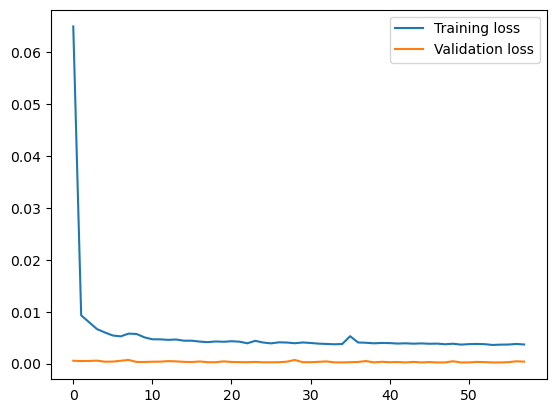

In [27]:
def train_model(x,y, batch_size = 64, hidden_size = 32, num_layers = 2, dropout_rate = 0.2, learning_rate = 0.001,input_size = 1): 
    epoch = 100

    part_train = 0.7
    part_valid = 0.2
    use_cuda = True

    # Data loading
    train_X = x[:int(part_train * len(x))]
    train_Y = y[:int(part_train * len(y))]
    valid_X = x[int(part_train * len(x)): int(part_train * len(x)) + int(part_valid * len(x))]
    valid_Y = y[int(part_train * len(y)): int(part_train * len(y)) + int(part_valid * len(y))]

    train_X, train_Y = torch.from_numpy(train_X).float().unsqueeze(-1), torch.from_numpy(train_Y).float()
    train_loader = DataLoader(TensorDataset(train_X, train_Y), batch_size=batch_size, shuffle=True)    

    valid_X, valid_Y = torch.from_numpy(valid_X).float().unsqueeze(-1), torch.from_numpy(valid_Y).float()
    valid_loader = DataLoader(TensorDataset(valid_X, valid_Y), batch_size=batch_size)

    # Training parameters
    device = torch.device("cuda:0" if use_cuda and torch.cuda.is_available() else "cpu") 
    model = GRUModel(input_size, hidden_size, num_layers, dropout_rate=dropout_rate).to(device)      
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.MSELoss()

    valid_loss_min = float("inf")
    bad_epoch = 0
    global_step = 0

    train_loss_array_per_epoch = []
    valid_loss_array_per_epoch = []

    # Training epochs
    for epoch in tqdm(range(epoch)):
        model.train(True)                  
        train_loss_array = []
        hidden_train = None

        #Train phase
        for i, batch in enumerate(train_loader):
            batch_x, batch_y = batch[0].to(device), batch[1].to(device)
            pred_y = model(batch_x) 

            optimizer.zero_grad()               
            loss = criterion(pred_y, batch_y)  
            loss.backward()                     
            optimizer.step()     

            train_loss_array.append(loss.item())
            global_step += 1
                
        #Eval phase
        model.eval()                    
        valid_loss_array = []

        for i, batch in enumerate(valid_loader):
            batch_v_x , batch_v_y= batch[0].to(device), batch[1].to(device)
            pred_Y= model(batch_v_x)

            loss = criterion(pred_Y, batch_v_y)  

            valid_loss_array.append(loss.item())

        train_loss_cur = np.mean(train_loss_array)
        valid_loss_cur = np.mean(valid_loss_array)
        train_loss_array_per_epoch.append(train_loss_cur)
        valid_loss_array_per_epoch.append(valid_loss_cur)
        

        # Save if better
        if valid_loss_cur < valid_loss_min:
            valid_loss_min = valid_loss_cur
            bad_epoch = 0
            torch.save(model.state_dict(),"GRUModel.pth")
        else:
            bad_epoch += 1
            if bad_epoch > 15:
                break
        
    # plt.plot(train_loss_array_per_epoch, label='Training loss')
    # plt.plot(valid_loss_array_per_epoch, label='Validation loss')
    # plt.legend()
    # plt.show()

train_model(x,y,batch_size=16, hidden_size=128, num_layers=1, dropout_rate=0.1, learning_rate=0.001,input_size=1)

## Test

In [21]:
def test_model(x,y, hidden_size = 32, num_layers = 2, dropout_rate = 0.2, input_size = 1): 
    use_cuda = True
    part_train = 0.7
    part_valid = 0.2

    test_X = x[int((part_train + part_valid) * len(x)):]
    true_Y = y[int((part_train + part_valid) * len(y)):]

    test_X = torch.from_numpy(test_X).float().unsqueeze(-1)
    test_set = TensorDataset(test_X)
    test_loader = DataLoader(test_set, batch_size=1)

    device = torch.device("cuda:0" if use_cuda and torch.cuda.is_available() else "cpu")
    model = GRUModel(input_size, hidden_size, num_layers).to(device)
    model.load_state_dict(torch.load("GRUModel.pth"))   

    result = torch.Tensor().to(device)

    model.eval()

    for _data in test_loader:
        data_X = _data[0].to(device)
        pred_X = model(data_X)
        cur_pred = torch.squeeze(pred_X, dim=0)
        result = torch.cat((result, cur_pred), dim=0)

    pred_Y = result.detach().cpu().numpy()
    
    return pred_Y, true_Y

In [22]:
# Compute the results
results = pd.read_csv('GRU_results.csv')

for bc in [16,64]:
    for layers in [1,2,3]:
        for hidden in [8,16,32,64,128]:
            for dropout in [0, 0.1]:
                for lr in [0.05, 0.01]:
                    if len(results[(results['Window'] == timeWindowToUse) & (results['layers'] == layers) & (results['hidden'] == hidden) & (results['batch_size'] == bc) & (results['dropout'] == dropout) & (results['lr'] == lr)]) > 0:
                         continue
                    train_model(x,y, batch_size=bc,hidden_size = hidden, num_layers = layers, dropout_rate = dropout, learning_rate = lr)
                    pred_Y, true_Y = test_model(x,y, hidden_size = hidden, num_layers = layers, dropout_rate = dropout)
                    mse = mean_squared_error(scaler_y.inverse_transform(true_Y.reshape(-1, 1)), scaler_y.inverse_transform(pred_Y.reshape(-1, 1)))
                    print(mse)
                    results = pd.concat([results, pd.DataFrame.from_records([{'Window': timeWindowToUse,'layers': layers,
                                         'hidden': hidden, 'batch_size' : bc,'dropout': dropout, 'lr': lr, 'mse': mse}])])
                    results.to_csv('GRU_results.csv', index=False)


 25%|██▌       | 25/100 [00:07<00:23,  3.14it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

6.085881807617991e+18


 37%|███▋      | 37/100 [00:12<00:20,  3.05it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

6.479007117175438e+18


 22%|██▏       | 22/100 [00:06<00:23,  3.32it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

6.203361935921848e+18


 36%|███▌      | 36/100 [00:10<00:18,  3.55it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

5.748623922583235e+18


 36%|███▌      | 36/100 [00:10<00:18,  3.44it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

6.454502052844843e+18


 34%|███▍      | 34/100 [00:09<00:19,  3.41it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

5.799990742332547e+18


 39%|███▉      | 39/100 [00:11<00:18,  3.35it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

8.110639702553265e+18


 22%|██▏       | 22/100 [00:07<00:25,  3.06it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

5.930423978337109e+18


 17%|█▋        | 17/100 [00:07<00:36,  2.29it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

6.862385258548998e+18


 63%|██████▎   | 63/100 [00:19<00:11,  3.30it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

5.896108528244666e+18


 25%|██▌       | 25/100 [00:07<00:22,  3.31it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

8.570710578440569e+18


 46%|████▌     | 46/100 [00:14<00:16,  3.21it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

7.682838650589356e+18


 35%|███▌      | 35/100 [00:13<00:25,  2.54it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

1.1088322072856537e+19


 53%|█████▎    | 53/100 [00:20<00:18,  2.58it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

7.008423321850276e+18


 34%|███▍      | 34/100 [00:12<00:23,  2.76it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

6.252592277846623e+18


 60%|██████    | 60/100 [00:22<00:15,  2.65it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

5.859086578124661e+18


 25%|██▌       | 25/100 [00:13<00:40,  1.85it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

7.429605353423271e+18


 37%|███▋      | 37/100 [00:19<00:32,  1.91it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

5.979973570799383e+18


 54%|█████▍    | 54/100 [00:28<00:24,  1.88it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

5.462496570143248e+18


 31%|███       | 31/100 [00:18<00:40,  1.69it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

5.570198343299965e+18


  0%|          | 0/100 [00:00<?, ?it/s]

8.776950135036417e+18


  0%|          | 0/100 [00:00<?, ?it/s]

6.319916603910173e+18


  0%|          | 0/100 [00:00<?, ?it/s]

6.765201788706154e+18


  0%|          | 0/100 [00:00<?, ?it/s]

1.2302067260922135e+19


  0%|          | 0/100 [00:00<?, ?it/s]

6.376117925446988e+18


  0%|          | 0/100 [00:00<?, ?it/s]

1.538861989764788e+19


  0%|          | 0/100 [00:00<?, ?it/s]

1.3346551110432938e+19


  0%|          | 0/100 [00:00<?, ?it/s]

1.1035991884944652e+19


  0%|          | 0/100 [00:00<?, ?it/s]

6.287207798215207e+18


  0%|          | 0/100 [00:00<?, ?it/s]

7.482504687964929e+18


  0%|          | 0/100 [00:00<?, ?it/s]

1.892292103278782e+19


  0%|          | 0/100 [00:00<?, ?it/s]

3.311452134467976e+19


  0%|          | 0/100 [00:00<?, ?it/s]

8.107828381914543e+19


  0%|          | 0/100 [00:00<?, ?it/s]

6.876916982562321e+18


  0%|          | 0/100 [00:00<?, ?it/s]

1.568595734788191e+19


  0%|          | 0/100 [00:00<?, ?it/s]

1.0917008957344332e+19


  0%|          | 0/100 [00:00<?, ?it/s]

1.0712428582972349e+20


  0%|          | 0/100 [00:00<?, ?it/s]

6.403610111428483e+18


  0%|          | 0/100 [00:00<?, ?it/s]

1.7850840380781717e+20


  0%|          | 0/100 [00:00<?, ?it/s]

1.0802402748394912e+19


  0%|          | 0/100 [00:00<?, ?it/s]

1.325896240024051e+19


  0%|          | 0/100 [00:00<?, ?it/s]

7.523738037347899e+18


  0%|          | 0/100 [00:00<?, ?it/s]

1.3006119646808492e+19


  0%|          | 0/100 [00:00<?, ?it/s]

1.3797137988063898e+19


  0%|          | 0/100 [00:00<?, ?it/s]

2.4584688024856252e+19


  0%|          | 0/100 [00:00<?, ?it/s]

1.0358298392290292e+19


  0%|          | 0/100 [00:00<?, ?it/s]

3.0876699604500247e+19


  0%|          | 0/100 [00:00<?, ?it/s]

1.3789110141461098e+19


  0%|          | 0/100 [00:00<?, ?it/s]

2.430146095581001e+20


  0%|          | 0/100 [00:00<?, ?it/s]

2.2088768687591e+19


  0%|          | 0/100 [00:00<?, ?it/s]

3.1756339082621768e+19


  0%|          | 0/100 [00:00<?, ?it/s]

1.085044548598458e+19


  0%|          | 0/100 [00:00<?, ?it/s]

1.1193354988226001e+20


  0%|          | 0/100 [00:00<?, ?it/s]

5.996623565512377e+18


  0%|          | 0/100 [00:00<?, ?it/s]

1.4504925627251327e+20


  0%|          | 0/100 [00:00<?, ?it/s]

9.227616417966471e+18


  0%|          | 0/100 [00:00<?, ?it/s]

7.303534525496339e+19


  0%|          | 0/100 [00:00<?, ?it/s]

3.754783328091211e+19


  0%|          | 0/100 [00:00<?, ?it/s]

4.1063854019898966e+20


  2%|▏         | 2/100 [00:00<00:07, 12.42it/s]

9.643616860054792e+18


 42%|████▏     | 42/100 [00:03<00:05, 11.54it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  2%|▏         | 2/100 [00:00<00:08, 11.65it/s]

7.162854258593105e+18


 67%|██████▋   | 67/100 [00:07<00:03,  8.94it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  1%|          | 1/100 [00:00<00:14,  6.88it/s]

5.685823714028466e+18


 36%|███▌      | 36/100 [00:04<00:08,  7.95it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  2%|▏         | 2/100 [00:00<00:09, 10.70it/s]

6.502291253774707e+18


 50%|█████     | 50/100 [00:05<00:05,  9.33it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  2%|▏         | 2/100 [00:00<00:09, 10.70it/s]

5.646292956043296e+18


 36%|███▌      | 36/100 [00:03<00:05, 10.77it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  1%|          | 1/100 [00:00<00:09,  9.98it/s]

6.743275307707561e+18


 51%|█████     | 51/100 [00:04<00:04, 11.20it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  2%|▏         | 2/100 [00:00<00:08, 12.07it/s]

6.308165131905402e+18


 18%|█▊        | 18/100 [00:01<00:07, 11.20it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  2%|▏         | 2/100 [00:00<00:08, 11.90it/s]

5.842077632717201e+18


 53%|█████▎    | 53/100 [00:05<00:04, 10.30it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  2%|▏         | 2/100 [00:00<00:09, 10.52it/s]

6.008525569475726e+18


 33%|███▎      | 33/100 [00:03<00:06,  9.97it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  2%|▏         | 2/100 [00:00<00:09, 10.30it/s]

7.096862141260658e+18


 48%|████▊     | 48/100 [00:04<00:05,  9.83it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  2%|▏         | 2/100 [00:00<00:09, 10.60it/s]

6.118657703376513e+18


 48%|████▊     | 48/100 [00:04<00:05, 10.01it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  2%|▏         | 2/100 [00:00<00:09, 10.44it/s]

7.860030724096525e+18


 54%|█████▍    | 54/100 [00:05<00:04, 10.30it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  1%|          | 1/100 [00:00<00:15,  6.39it/s]

6.209002676992359e+18


 55%|█████▌    | 55/100 [00:08<00:06,  6.52it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

7.05095275691352e+18


 54%|█████▍    | 54/100 [00:08<00:07,  6.53it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

7.092861620002213e+18


 35%|███▌      | 35/100 [00:05<00:10,  6.44it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  1%|          | 1/100 [00:00<00:15,  6.56it/s]

7.024832031668263e+18


 50%|█████     | 50/100 [00:07<00:07,  6.58it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

6.17223570133456e+18


 25%|██▌       | 25/100 [00:05<00:17,  4.23it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

7.45850943707186e+18


 41%|████      | 41/100 [00:09<00:13,  4.28it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

6.223214281793399e+18


 32%|███▏      | 32/100 [00:07<00:15,  4.29it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/100 [00:00<?, ?it/s]

7.990762733001581e+18


 33%|███▎      | 33/100 [00:07<00:15,  4.24it/s]
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  1%|          | 1/100 [00:00<00:14,  7.02it/s]

6.333581700854201e+18


  1%|          | 1/100 [00:00<00:14,  6.84it/s]

8.750161992444995e+18


  1%|          | 1/100 [00:00<00:14,  6.74it/s]

7.667116039877064e+18


  1%|          | 1/100 [00:00<00:15,  6.46it/s]

6.1839941812156e+18


  1%|          | 1/100 [00:00<00:15,  6.21it/s]

1.403560148517515e+19


  1%|          | 1/100 [00:00<00:15,  6.55it/s]

1.3486546930053896e+19


  1%|          | 1/100 [00:00<00:14,  6.73it/s]

5.918832405567549e+18


  1%|          | 1/100 [00:00<00:14,  6.69it/s]

8.899092800012274e+18


  1%|          | 1/100 [00:00<00:19,  5.20it/s]

1.4835885588356604e+19


  1%|          | 1/100 [00:00<00:17,  5.71it/s]

7.11617424255969e+18


  1%|          | 1/100 [00:00<00:17,  5.52it/s]

9.452465638386012e+18


  1%|          | 1/100 [00:00<00:18,  5.35it/s]

8.137470885209559e+18


  0%|          | 0/100 [00:00<?, ?it/s]

9.678710616264497e+18


  0%|          | 0/100 [00:00<?, ?it/s]

1.0182814218209678e+20


  0%|          | 0/100 [00:00<?, ?it/s]

1.0160195479467299e+19


  0%|          | 0/100 [00:00<?, ?it/s]

2.2720677675424068e+19


  0%|          | 0/100 [00:00<?, ?it/s]

1.1659212049901085e+19


  0%|          | 0/100 [00:00<?, ?it/s]

7.263053217334604e+19


  0%|          | 0/100 [00:00<?, ?it/s]

7.001365883097289e+18


  0%|          | 0/100 [00:00<?, ?it/s]

2.6177269657659752e+19


  0%|          | 0/100 [00:00<?, ?it/s]

7.495081981999973e+18


  0%|          | 0/100 [00:00<?, ?it/s]

9.54533641663946e+18


  0%|          | 0/100 [00:00<?, ?it/s]

7.291432788177964e+18


  0%|          | 0/100 [00:00<?, ?it/s]

7.238018808976756e+18


  0%|          | 0/100 [00:00<?, ?it/s]

1.89774007581507e+19


  0%|          | 0/100 [00:00<?, ?it/s]

8.761710646161822e+18


  0%|          | 0/100 [00:00<?, ?it/s]

9.922285288452596e+18


  0%|          | 0/100 [00:00<?, ?it/s]

1.1593588938626376e+19


  0%|          | 0/100 [00:00<?, ?it/s]

1.3104603397599484e+19


  0%|          | 0/100 [00:00<?, ?it/s]

6.8351105384747e+18


  0%|          | 0/100 [00:00<?, ?it/s]

9.48942108410635e+18


  0%|          | 0/100 [00:00<?, ?it/s]

5.609926515550604e+19


  0%|          | 0/100 [00:00<?, ?it/s]

1.0895106006768433e+19


  0%|          | 0/100 [00:00<?, ?it/s]

5.4157377403051385e+19


  0%|          | 0/100 [00:00<?, ?it/s]

5.627769138889229e+18


  0%|          | 0/100 [00:00<?, ?it/s]

5.755452593517617e+19


  0%|          | 0/100 [00:00<?, ?it/s]

1.508008794445935e+19


  0%|          | 0/100 [00:00<?, ?it/s]

2.126839619977366e+19


  0%|          | 0/100 [00:00<?, ?it/s]

8.558247154410542e+18


  0%|          | 0/100 [00:00<?, ?it/s]

1.637644857866263e+20


 64%|██████▍   | 64/100 [01:03<00:35,  1.01it/s]


1.124967414889111e+19


In [23]:
import pandas as pd
pd.read_csv('GRU_results.csv').sort_values('mse').head(20)

,Window,layers,hidden,dropout,lr,mse,batch_size
0,0.0,0.0,0.0,0.0,0.00,5.214645e+18,0.0
19,15.0,1.0,128.0,0.1,0.05,5.462497e+18,16.0
20,15.0,1.0,128.0,0.1,0.01,5.570198e+18,16.0
114,15.0,3.0,64.0,0.0,0.01,5.627769e+18,64.0
64,15.0,1.0,8.0,0.1,0.01,5.646293e+18,64.0
62,15.0,1.0,8.0,0.0,0.01,5.685824e+18,64.0
4,15.0,1.0,8.0,0.1,0.01,5.748624e+18,16.0
6,15.0,1.0,16.0,0.0,0.01,5.799991e+18,16.0
67,15.0,1.0,16.0,0.1,0.05,5.842078e+18,64.0
16,15.0,1.0,64.0,0.1,0.01,5.859087e+18,16.0
